# CAP curves & Recall @ top p

This notebook explores the CAP curves and the recall at top p metric for a set of models.

The goal is to understand how well the models perform in terms of recall at different sample percentages.

Author: https://github.com/deburky

In [1]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

RANDOM_STATE = 123456
PREVALENCE = 0.046

# Generate a random classification problem
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    weights=[1 - PREVALENCE, PREVALENCE],
    class_sep=0.5,
    n_clusters_per_class=2,
    random_state=RANDOM_STATE,
)

X_, y_ = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    weights=[1 - PREVALENCE, PREVALENCE],
    class_sep=0.8,
    n_clusters_per_class=2,
    random_state=RANDOM_STATE,
)

logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X, y)
preds = logistic_regression.predict_proba(X)[:, 1]

logistic_regression_ = LogisticRegression(max_iter=1000)
logistic_regression_.fit(X_, y_)
preds_ = logistic_regression.predict_proba(X_)[:, 1]

print(f"Prevalence model 1: {y_.mean():.2%}")
print(f"Prevalence model 2: {y_.mean():.2%}")

gini = 2 * roc_auc_score(y, preds) - 1
print(f"Gini model 1: {gini:.0%}")

gini_ = 2 * roc_auc_score(y, preds_) - 1
print(f"Gini model 2: {gini_:.0%}")

Prevalence model 1: 5.00%
Prevalence model 2: 5.00%
Gini model 1: 72%
Gini model 2: 86%


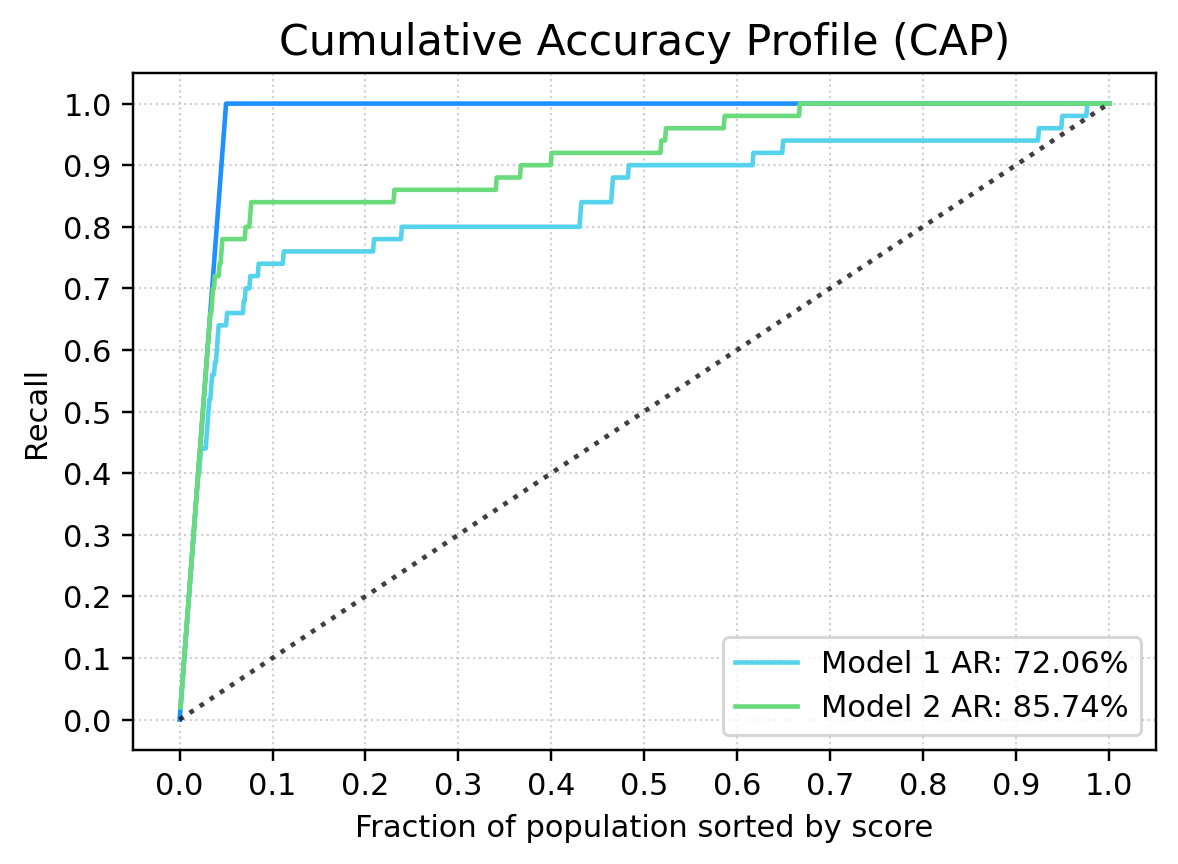

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'


def plot_performance(models, predictions, ginis):
    # sourcery skip: extract-duplicate-method
    _, ax1 = plt.subplots(figsize=(6, 4), dpi=110)
    colors = ["#55d3ed", "#69db7c", "#ffa94d", "#c430c1"]

    # Plot ideal CAP curve
    bad_rate = predictions["label"].mean()
    ideal = [0, bad_rate, 1], [0, 1, 1]  # Ideal curve

    # Plot ideal CAP curve
    ax1.plot(ideal[0], ideal[1], color="dodgerblue")

    for i, _ in enumerate(models):
        # Data preparation for CAP curve
        preds_filtered = predictions[[f"model_{i}", "label"]].copy()
        preds_filtered = preds_filtered.rename(columns={f"model_{i}": "prediction"})
        preds_filtered = preds_filtered.sort_values(
            by="prediction", ascending=False
        ).reset_index(drop=True)

        # x-axis
        preds_filtered["id"] = preds_filtered.index
        total_id = preds_filtered["id"].max()
        preds_filtered["cum_id"] = (1 + preds_filtered["id"]) / total_id

        # y-axis
        cumulative_bad = preds_filtered["label"].cumsum()
        total_bad = preds_filtered["label"].sum()
        preds_filtered["cumulative_bad"] = cumulative_bad / total_bad

        # Plot CAP curve
        ax1.plot(
            preds_filtered["cum_id"],
            preds_filtered["cumulative_bad"],
            label=f"Model {i + 1} AR: {ginis.loc[i, 'gini']:.2%}",
            color=colors[i],
        )

        cap_data = preds_filtered.copy()

        # CAP plot formatting
        ax1.set_xticks(np.arange(0, 1.1, 0.1))
        ax1.set_yticks(np.arange(0, 1.1, 0.1))
        ax1.set_xlabel("Fraction of population sorted by score")
        ax1.set_ylabel("Recall")
        ax1.set_title("Cumulative Accuracy Profile (CAP)", fontsize=14)
        ax1.grid(True, which="both", linestyle="dotted", linewidth=0.7, alpha=0.6)
        ax1.plot([0, 1], [0, 1], linestyle="dotted", color="black", alpha=0.5)
        ax1.legend(loc="lower right", fontsize=10)

    return cap_data


cap_data = plot_performance(
    models=[logistic_regression, logistic_regression_],
    predictions=pd.DataFrame({"model_0": preds, "model_1": preds_, "label": y}),
    ginis=pd.DataFrame({"gini": [gini, gini_]}),
)


## Recall @ top p inside CAP curve

We define the recall at top p as the proportion of relevant items that are retrieved in the top p items.

This is a common metric used in information retrieval and recommendation systems.

In [3]:
import numpy as np


# calculate recall at p%
def calculate_recall_at_p_percent(preds, y, percent=0.05):
    # Sort predictions and get the top p% indices
    top_percent_indices = np.argsort(preds)[::-1][: int(len(preds) * percent)]

    # Calculate recall
    true_positives = np.sum(y[top_percent_indices])
    false_negatives = np.sum(y) - true_positives
    return true_positives / (true_positives + false_negatives)


recall_at_p_percent = calculate_recall_at_p_percent(preds, y, percent=0.05)
print(f"Recall at p% - model 1: {recall_at_p_percent:.4f}")

recall_at_p_percent = calculate_recall_at_p_percent(preds_, y, percent=0.05)
print(f"Recall at p% - model 2: {recall_at_p_percent:.4f}")

Recall at p% - model 1: 0.6400
Recall at p% - model 2: 0.7800


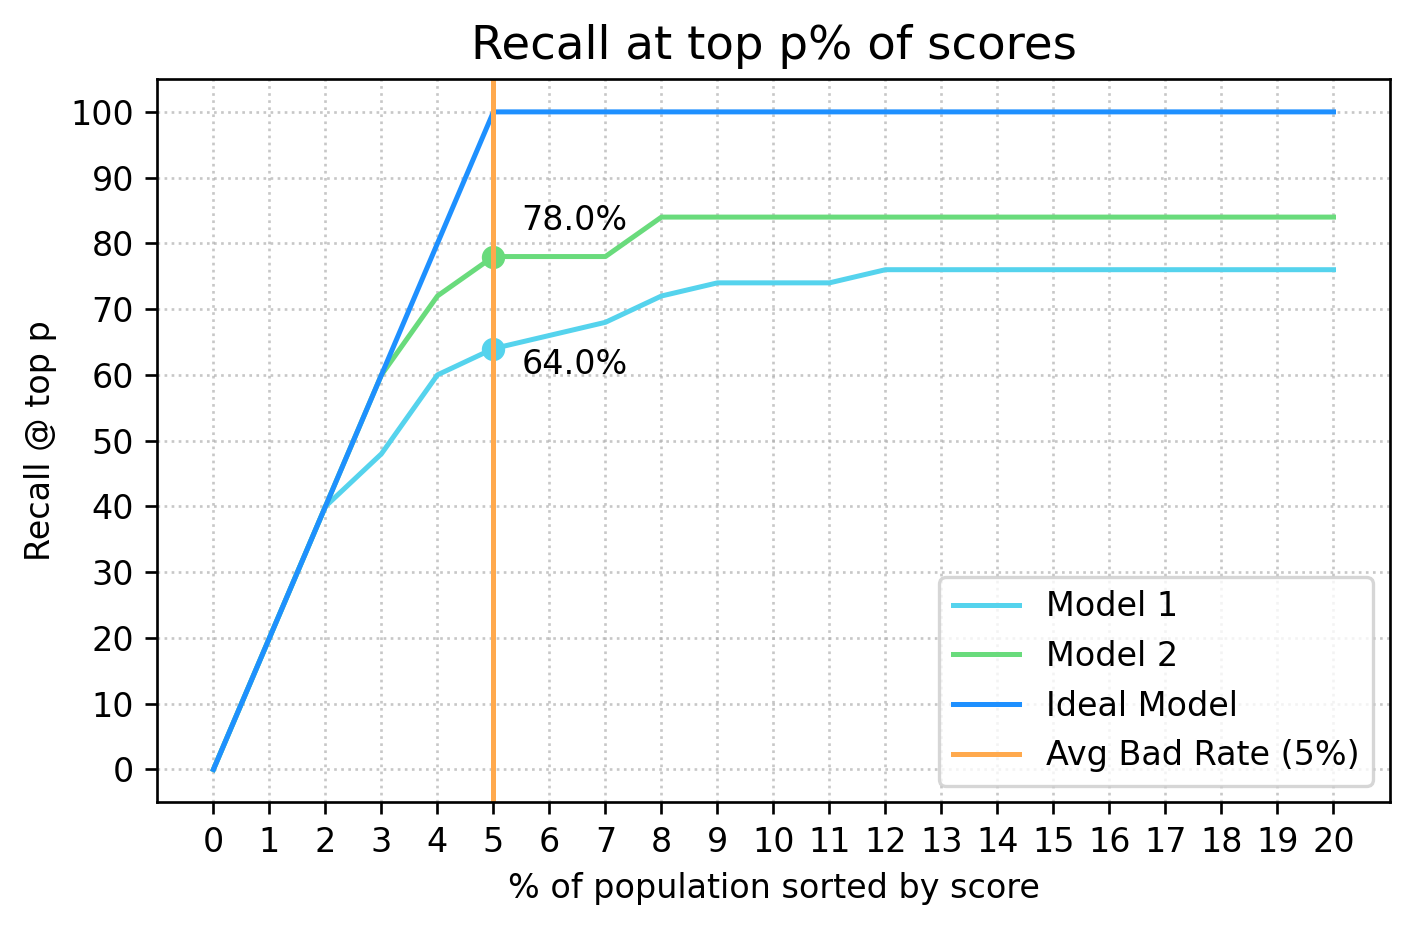

In [4]:
from matplotlib import pyplot as plt


def plot_recall_at_percentile_dual(preds1, preds2, y, max_percent=0.2, step=0.01):
    colors = ["#55d3ed", "#69db7c", "#ffa94d", "#c430c1"]
    percentiles = np.linspace(0, max_percent, int(max_percent / step) + 1)
    recalls1, recalls2 = [], []

    total_positives = np.sum(y)
    bad_rate = y.mean()
    ideal_x = [0, bad_rate, max_percent]
    ideal_y = [0, 1, 1]

    # Compute model recall curves
    for p in percentiles:
        k = int(len(y) * p)
        top1 = np.argsort(preds1)[::-1][:k]
        top2 = np.argsort(preds2)[::-1][:k]

        recalls1.append(np.sum(y[top1]) / total_positives if total_positives > 0 else 0)
        recalls2.append(np.sum(y[top2]) / total_positives if total_positives > 0 else 0)

    # Plot
    plt.figure(figsize=(6, 4), dpi=120)
    plt.plot(
        percentiles * 100, np.array(recalls1) * 100, color=colors[0], label="Model 1"
    )
    plt.plot(
        percentiles * 100, np.array(recalls2) * 100, color=colors[1], label="Model 2"
    )
    plt.plot(
        np.array(ideal_x) * 100,
        np.array(ideal_y) * 100,
        color="dodgerblue",
        label="Ideal Model",
    )

    # Add vertical line at 5%
    plt.axvline(5, color="#ffa94d", label="Avg Bad Rate (5%)")

    # Annotate recall at 5%
    idx_5 = np.where(np.isclose(percentiles * 100, 5, atol=0.01))[0][0]
    r1_5 = recalls1[idx_5] * 100
    r2_5 = recalls2[idx_5] * 100
    plt.scatter([5], [r1_5], color=colors[0])
    plt.scatter([5], [r2_5], color=colors[1])
    plt.text(5.5, r1_5 - 5.0, f"{r1_5:.1f}%", color="black", va="bottom", fontsize=10)
    plt.text(5.5, r2_5 + 8.0, f"{r2_5:.1f}%", color="black", va="top", fontsize=10)

    plt.xlabel("% of population sorted by score")
    plt.ylabel("Recall @ top p")
    plt.title("Recall at top p% of scores", fontsize=14)
    plt.grid(True, linestyle="dotted", alpha=0.7)
    plt.xticks(np.arange(0, max_percent * 100 + 1, step * 100))
    plt.yticks(np.arange(0, 101, 10))
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_recall_at_percentile_dual(preds, preds_, y, max_percent=0.2, step=0.01)

## Precision-recall curve @ top p

If you think about it, each incorrectly ordered observation is a false negative.

This means we can look into a precision-recall curve at top predictions only to get a better understanding of the model performance.

Model 1 AP@top5.00%: 0.9296
Model 2 AP@top5.00%: 0.9857


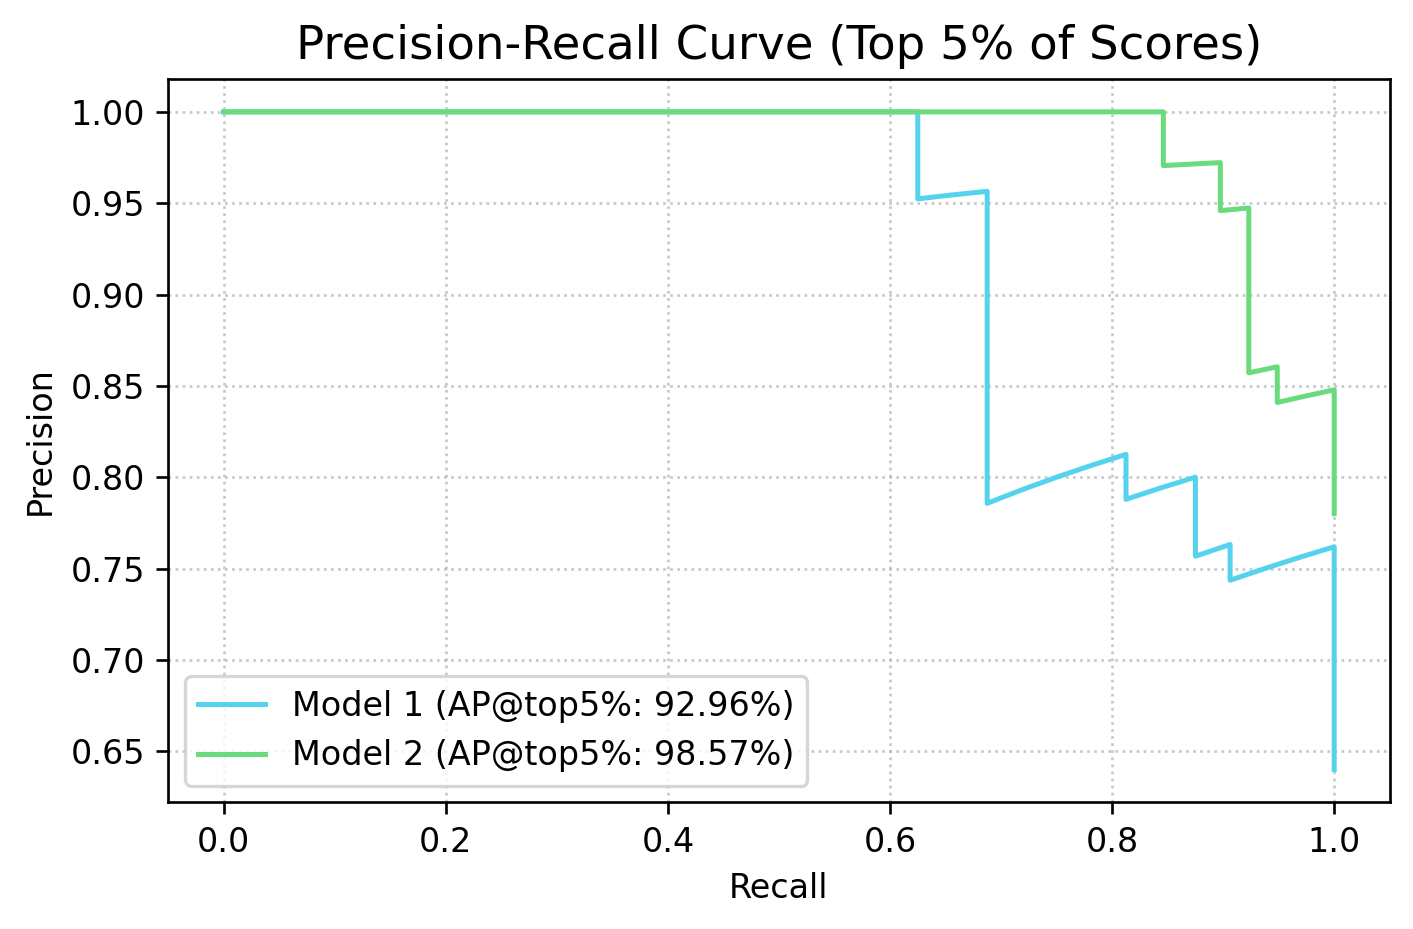

In [10]:
from sklearn.metrics import average_precision_score, precision_recall_curve

colors = ["#55d3ed", "#69db7c", "#ffa94d", "#c430c1"]

PERCENTAGE = 0.05
# Take top 20% of population sorted by score
cutoff = int(len(y) * PERCENTAGE)

# Sort by score descending
sorted_idx1 = np.argsort(preds)[::-1][:cutoff]
sorted_idx2 = np.argsort(preds_)[::-1][:cutoff]

# Calculate precision-recall curves on top 20% population
precision1, recall1, _ = precision_recall_curve(y[sorted_idx1], preds[sorted_idx1])
precision2, recall2, _ = precision_recall_curve(y[sorted_idx2], preds_[sorted_idx2])

# AP for top 20%
ap1 = average_precision_score(y[sorted_idx1], preds[sorted_idx1])
ap2 = average_precision_score(y[sorted_idx2], preds_[sorted_idx2])

print(f"Model 1 AP@top{PERCENTAGE:.2%}: {ap1:.4f}")
print(f"Model 2 AP@top{PERCENTAGE:.2%}: {ap2:.4f}")

# Plot PR curves
plt.figure(figsize=(6, 4), dpi=120)
plt.plot(
    recall1,
    precision1,
    color=colors[0],
    label=f"Model 1 (AP@top{PERCENTAGE:.0%}: {ap1:.2%})",
)
plt.plot(
    recall2,
    precision2,
    color=colors[1],
    label=f"Model 2 (AP@top{PERCENTAGE:.0%}: {ap2:.2%})",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (Top {PERCENTAGE:.0%} of Scores)", fontsize=14)
plt.grid(True, linestyle="dotted", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## CAP and PR curves for the two models

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc

%config InlineBackend.figure_format = 'retina'


def plot_performance(models, predictions, ginis):
    # sourcery skip: extract-duplicate-method
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), dpi=110)
    # Add width between ax1 and ax2
    plt.subplots_adjust(wspace=0.2)
    colors = ["#55d3ed", "#69db7c", "#ffa94d", "#c430c1"]

    # CAP Curve (Left)
    bad_rate = predictions["label"].mean()
    ideal = [0, bad_rate, 1], [0, 1, 1]
    ax1.plot(ideal[0], ideal[1], color="dodgerblue")

    for i, _ in enumerate(models):
        # Data prep for CAP
        preds_filtered = predictions[[f"model_{i}", "label"]].copy()
        preds_filtered = preds_filtered.rename(columns={f"model_{i}": "prediction"})
        preds_filtered = preds_filtered.sort_values(
            by="prediction", ascending=False
        ).reset_index(drop=True)

        preds_filtered["id"] = preds_filtered.index
        total_id = preds_filtered["id"].max()
        preds_filtered["cum_id"] = (1 + preds_filtered["id"]) / total_id

        cumulative_bad = preds_filtered["label"].cumsum()
        total_bad = preds_filtered["label"].sum()
        preds_filtered["cumulative_bad"] = cumulative_bad / total_bad

        # CAP plot
        ax1.plot(
            preds_filtered["cum_id"],
            preds_filtered["cumulative_bad"],
            label=f"Model {i + 1} AR: {ginis.loc[i, 'gini']:.2%}",
            color=colors[i],
        )

        # PR Curve (Right)
        precision, recall, _ = precision_recall_curve(
            predictions["label"], predictions[f"model_{i}"]
        )
        pr_auc = auc(recall, precision)
        ax2.plot(
            recall,
            precision,
            label=f"Model {i + 1} PR AUC: {pr_auc:.2%}",
            color=colors[i],
        )

    # CAP formatting
    ax1.set_xticks(np.arange(0, 1.1, 0.1))
    ax1.set_yticks(np.arange(0, 1.1, 0.1))
    ax1.set_xlabel("Fraction of population sorted by score")
    ax1.set_ylabel("Recall")
    ax1.set_title("Cumulative Accuracy Profile (CAP)", fontsize=14)
    ax1.grid(True, linestyle="dotted", alpha=0.6)
    ax1.plot([0, 1], [0, 1], linestyle="dotted", color="black", alpha=0.5)
    ax1.legend(loc="lower right", fontsize=10)

    # PR formatting
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("Precision-Recall Curve", fontsize=14)
    ax2.grid(True, linestyle="dotted", alpha=0.6)
    ax2.legend(loc="lower left", fontsize=10)

    return


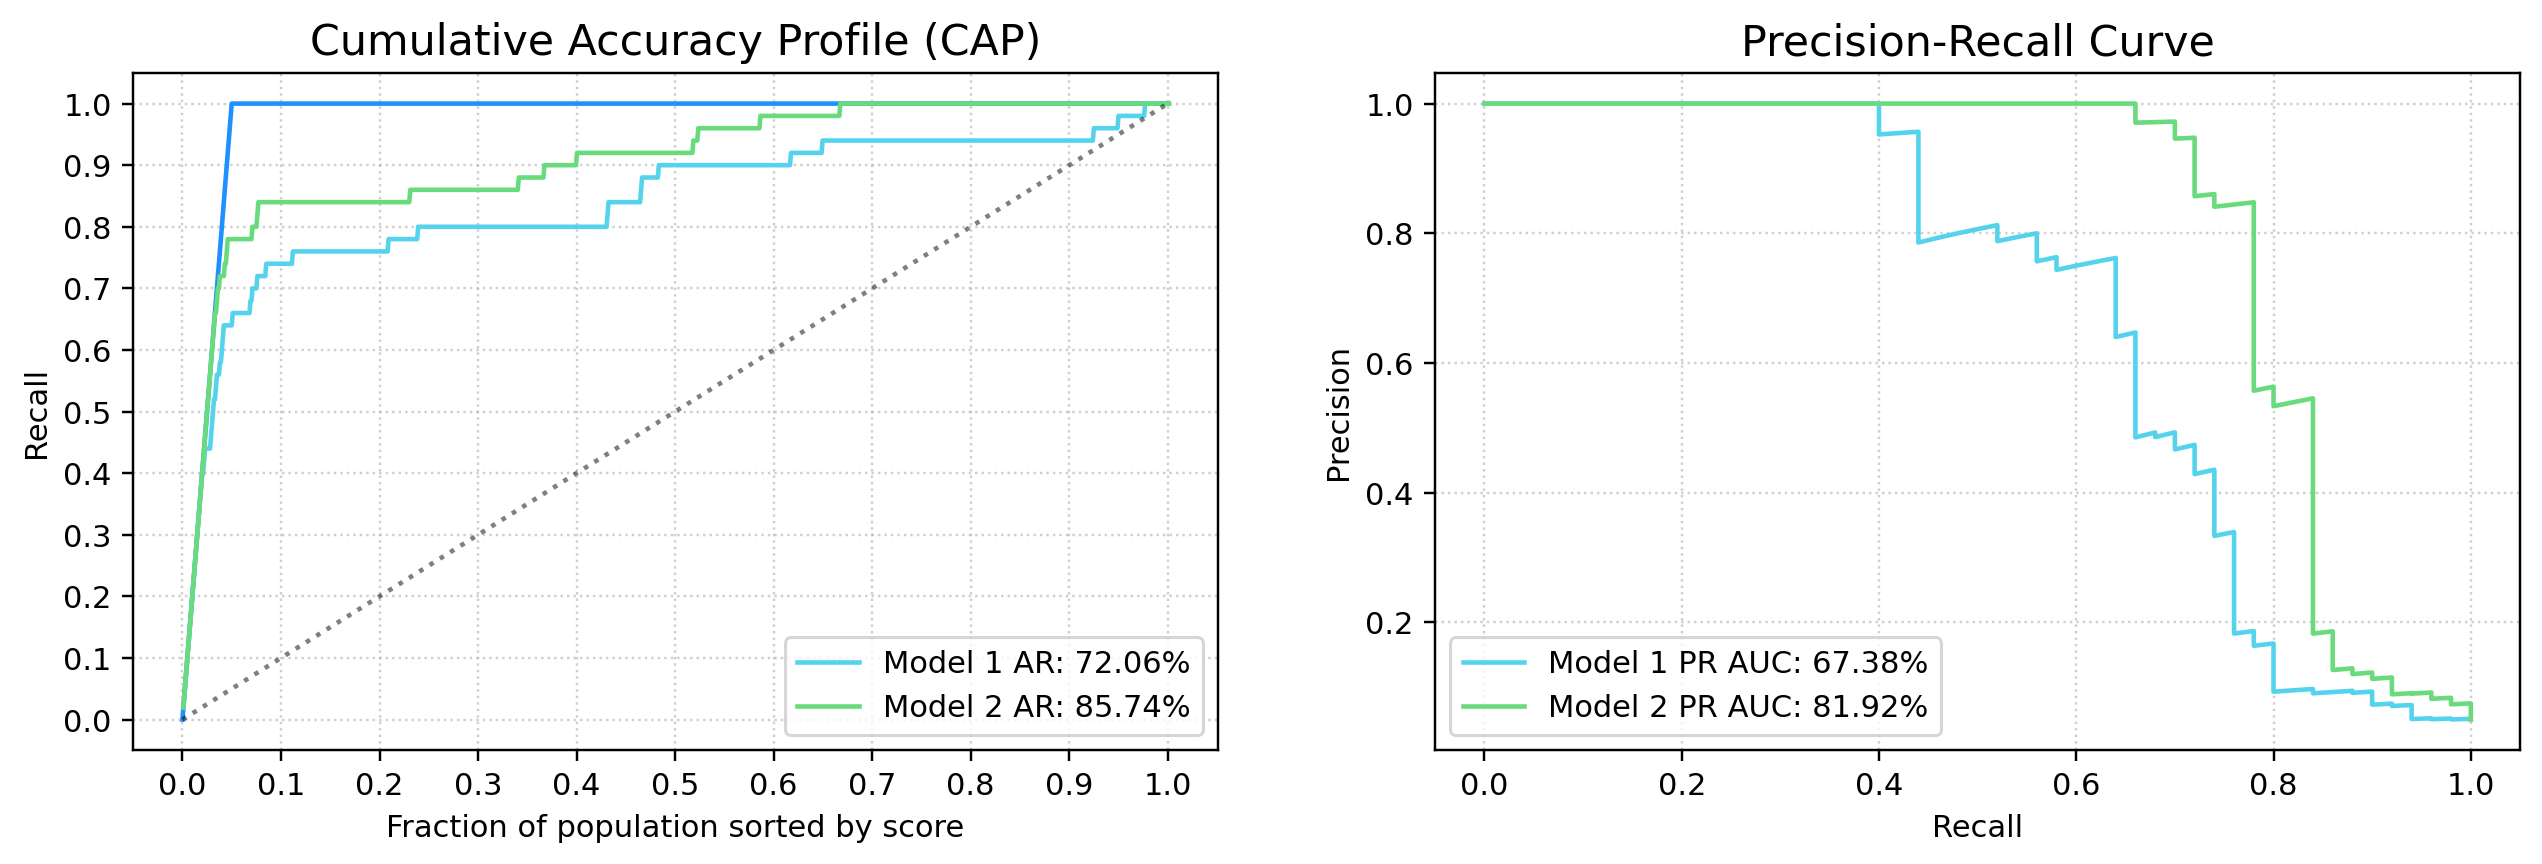

In [14]:
plot_performance(
    models=[logistic_regression, logistic_regression_],
    predictions=pd.DataFrame({"model_0": preds, "model_1": preds_, "label": y}),
    ginis=pd.DataFrame({"gini": [gini, gini_]}),
)